In [1]:
import re
import fileinput
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/CS7643_Group_Project_Spring_2021/

/content/gdrive/MyDrive/CS7643_Group_Project_Spring_2021


In [ ]:
%cd data/vilio/ernie-vil/

/content/gdrive/My Drive/CS7643_Group_Project_Spring_2021/data/vilio/ernie-vil


In [ ]:
!pip install paddlepaddle-gpu==1.8.3.post97
!pip install json-lines
!pip install ImageHash

In [ ]:
"""
Trains ERNIE

- Will output and OVERWRITE to ernie-vil/output_hm 
  - if you run Large then Small, Small wil OVERWRITE Large
- Make sure to have all data in the correct place (../ernie-vil/data/hm)
  1) hateful memes original dataset 
    - images as img/
    - 5 JSONL files that come with original hateful memes data
  2) MMF Detectron TextQA LMDB dir
    - Detectron.lmbd/
      - From this command !kaggle datasets download muennighoff/hmfeatureszipfin
      - Setup Kaggle account if you haven't &  create an API key
  3) Actual detectron2 hateful meme features
    - hm_vgattr5050.tsv, etc
    - NOTE: his bash scripts will transform / overwrite this data BUT it
      seems like you only have to put it in there once

NOTES:
- unzip tar files with !tar -xvzf FILENAME.tar.gz
- Make sure you're on a GPU
"""
!bash bash/training/EL/hm_EL.sh

In [ ]:
def get_step_metrics(line):
  metrics = line.replace(' ', '').split(',')
  metrics = list(map(lambda x: x.split(':'), metrics))
  step = int(metrics[2][1])
  loss = float(metrics[3][1])
  acc = float(metrics[4][1])

  return step, loss, acc

In [ ]:
i = 0
steps = []
losses = []
find_loss = re.compile(r'loss:')
accs = []
find_acc = re.compile(r'acc:')
avrg_accs = []
find_average_acc = re.compile('average_acc:')
rocaucs = []
find_rocauc = re.compile('rocauc:')
for line in fileinput.input("ALL_EL_output.log"):
  try:
    if find_loss.search(line):
      step, loss, acc = get_step_metrics(line)
      steps += [step]
      losses += [loss]
      accs += [acc]
    elif find_average_acc.search(line):
      ave = float(line.replace(' ', '').split(':')[1])
      avrg_accs += [ave]
    elif find_rocauc.search(line):
      rocauc = float(line.replace(' ', '').split(':')[1])
      rocaucs += [rocauc]
  except Exception as e:
    print(line)
    print(e)
    break



In [ ]:
fileinput.close()

In [ ]:
models = [
          'EL36', 'EL36', 'EL36',
          'ELVCR36', 'ELVCR36', 'ELVCR36',
          'ELVCR50', 'ELVCR50', 'ELVCR50',
          'EL72', 'EL72', 'EL72',
          'ELVCR72', 'ELVCR72', 'ELVCR72'
]
epochs = list(np.arange(1,4))*5
plot_rocaucs = pd.DataFrame({
    'ERNIE-ViL Type': models,
    'Epoch': epochs,
    'ROCAUC': rocaucs
})

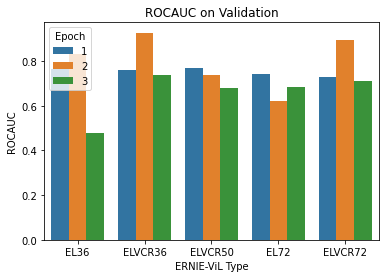

In [ ]:
plt.clf()
sns.barplot(
    x='ERNIE-ViL Type', y='ROCAUC', hue='Epoch', data=plot_rocaucs
)
plt.title("ROCAUC on Validation")
plt.savefig('./ERNIE_ROCAUC.pdf')

In [ ]:
plot_loss = pd.DataFrame({
    'Batch Step': steps[:250],
    'EL36': savgol_filter(losses[250:500], 201, 3),
    'ELVCR36': savgol_filter(losses[750:1_000], 201, 3),
    'ELVCR50': savgol_filter(losses[1_250:1_500], 201, 3),
    'EL72': savgol_filter(losses[1_750:2_000], 201, 3),
    'ELVCR72': savgol_filter(losses[2_250:], 201, 3),
})

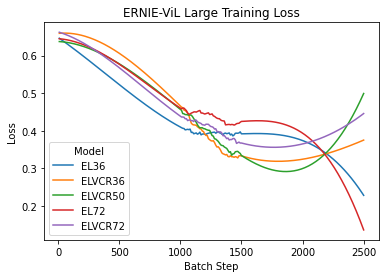

In [ ]:
plt.clf()
sns.lineplot(
    x='Batch Step',
    y='Loss',
    hue='Model',
    data=pd.melt(
        plot_loss,
        'Batch Step',
        var_name='Model',
        value_name='Loss'
    )
)
plt.title("ERNIE-ViL Large Training Loss")
plt.savefig("./ERNIE_loss.pdf")

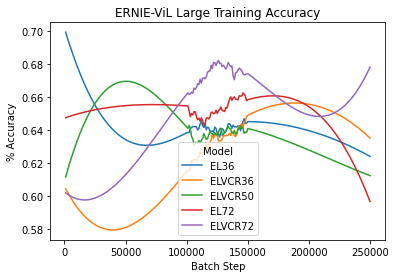

In [ ]:
plt.clf()
plot_accs = pd.DataFrame({
    'Batch Step': np.array(steps[:250]) * 100,
    'EL36': savgol_filter(accs[250:500], 201, 3),
    'ELVCR36': savgol_filter(accs[750:1_000], 201, 3),
    'ELVCR50': savgol_filter(accs[1_250:1_500], 201, 3),
    'EL72': savgol_filter(accs[1_750:2_000], 201, 3),
    'ELVCR72': savgol_filter(accs[2_250:], 201, 3),
})
sns.lineplot(
    x='Batch Step',
    y='% Accuracy',
    hue='Model',
    data=pd.melt(
        plot_accs,
        'Batch Step',
        var_name='Model',
        value_name='% Accuracy'
    )
)
plt.title("ERNIE-ViL Large Training Accuracy")
plt.savefig("ERNIE-ViL_acc.pdf")

In [ ]:
!git status